# To Do

1. Handle artists with < 10 top tracks (Done)
2. Only include "popular" artists
    - Define a popularity threshold
3. Make work on albums by filtering out albums with
    - < 6 or 7 tracks (Done)
    - removing duplicate songs
    - keeping only primary artist albums for that artist (Done)

In [399]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import joblib
import pandas as pd
import numpy as np
import scipy.stats as spst
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [217]:
client_credentials_manager = SpotifyClientCredentials(client_id = '',
                                                     client_secret = '')

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [232]:
def get_artist_id_from_name(name):
    results = sp.search(q='artist:' + name, type='artist', limit = 1)
    return name, results['artists']['items'][0]['id']

In [219]:
def get_artists_from_playlist(creator, playlist_uri):
    results = sp.user_playlist(creator, playlist_uri, fields = "tracks, next")
    
    track_names = [x['track']['name'] if x['track'] else None for x in results['tracks']['items']]
    track_names = [x for x in track_names if x is not None]
    
    artist_names = [x['track']['artists'][0]['name'] if x['track'] else None for x in results['tracks']['items']]
    artist_names = [x for x in artist_names if x is not None]
    
    artist_uri = [x['track']['artists'][0]['uri'] if x['track'] else None for x in results['tracks']['items']]
    artist_uri = [x for x in artist_uri if x is not None]
    
    return zip(artist_names, artist_uri)

In [220]:
def get_top_tracks_data_from_artist_uri(artist_uri):
    results = sp.artist_top_tracks(artist_uri)
    
    uris = [x['uri'] for x in results['tracks']]
    names = [x['name'] for x in results['tracks']]
    
    return zip(names, uris)

In [354]:
def get_artist_popularity(artist_id):
    data = sp.artist(artist_id)
    popularity = data['popularity']
    return popularity

In [221]:
def audio_features_from_track_uri(track_uri, relevant_features = ['energy', 'liveness', 'speechiness', 'acousticness',
                                                      'instrumentalness', 'time_signature', 'danceability', 
                                                      'key', 'loudness', 'valence', 'tempo']
                                ):
    audio_features_data = sp.audio_features(tracks = [track_uri])
    relevant_features = pull_relevant_audio_features(audio_features_data[0], relevant_features)
    
    return relevant_features

In [222]:
def pull_relevant_audio_features(features_list,
                                 relevant_features = ['energy', 'liveness', 'speechiness', 'acousticness',
                                                      'instrumentalness', 'time_signature', 'danceability', 
                                                      'key', 'loudness', 'valence', 'tempo']
                                ):
    
    
    feat_pair = []
    for feat in relevant_features:
        feat_pair.append( (feat, features_list[feat]) )
    return feat_pair

In [223]:
def creat_artist_feature_dataframe(artist_uri):
    artist_tracks_data = get_top_tracks_data_from_artist_uri(artist_uri)
    uri_list = [data for name, data in artist_tracks_data]
    name_list = [name for name, data in artist_tracks_data]
    
    artist_top_track_audio_data = zip(
        [x[0] for x in artist_tracks_data],
        [audio_features_from_track_uri(x[1]) for x in artist_tracks_data]
    )
    
    audio_feature_df = pd.DataFrame([dict(data) for name, data in artist_top_track_audio_data])
    audio_feature_df_with_uri = pd.concat(
        [audio_feature_df,
         pd.Series(uri_list).rename('track_uri'),
         pd.Series(name_list).rename('track_name')
        ],
        axis = 1
    )
    
    return audio_feature_df_with_uri

In [224]:
def tempo_scale(x):
    return (x - 40) / (200 - 40)

def loudness_scale(x):
    return (x - -60) / (0 - -60)

In [225]:
def cluster_tightness_metric(dataframe, cluster_center_array):
    return np.sum((dataframe.as_matrix() - cluster_center_array)**2)
    

In [226]:
def cluster_tightness_metric(dataframe, cluster_center_array):
    return np.sqrt(np.sum((dataframe.as_matrix() - cluster_center_array)**2))
    

In [461]:
def cluster_tightness_metric(dataframe, cluster_center_array):
    return np.sum(np.sqrt(np.sum((dataframe.as_matrix() - cluster_center_array)**2, axis = 1)))

In [459]:
def cluster_tightness_metric(dataframe, cluster_center_array):
    return np.sum(np.sum((dataframe.as_matrix() - cluster_center_array)**2, axis = 1))

In [228]:
# evaluate any given artist by name
def evaluate_artist_by_name_top_tracks(artist_name):
    artist_tup = get_artist_id_from_name(artist_name)
    
    artist_df = creat_artist_feature_dataframe(artist_tup[1])
    
    key_features = ['acousticness', 'danceability', 'energy', 'valence',
                'instrumentalness', 'loudness_scaled', 'speechiness', 'tempo_scaled']
    
    relevant = artist_df.copy()
    relevant['loudness_scaled'] = relevant.loudness.apply(loudness_scale)
    relevant['tempo_scaled'] = relevant.tempo.apply(tempo_scale)
    
    km = KMeans(n_clusters=1)
    km.fit(relevant[key_features])
    center_coordinates = km.cluster_centers_# same as np.mean(relevant[key_features], axis = 0)
    
    cluster_tightness = cluster_tightness_metric(relevant[key_features], center_coordinates)
    
    return artist_tup[0], cluster_tightness, artist_tup[1]

In [385]:
# evaluate all artists in a playlist
def evaluate_artists_in_playlist(playlist_owner, playlist_uri):
    
    # get artists from playlist
    artists_in_playlist_data = get_artists_from_playlist(playlist_owner, playlist_uri)
    
    # get artist top tracks and create dictionary
    artists_feature_dfs = dict()
    
    for artist, uri in artists_in_playlist_data:
        
        # only evaluate artists above a popularity threshold of 60
        threshold = 60
        popularity = get_artist_popularity(uri)
        if popularity < threshold:
            print '{0} not popular enough'.format(repr(artist))
            continue
            
        if artist not in artists_feature_dfs:
            print artist
            df = creat_artist_feature_dataframe(uri)
            
            # don't keep artists with fewer than 10 top hits
            if df.shape[0] < 10:
                continue
                
            artists_feature_dfs[artist] = df
            
            time.sleep(2)
            
        else:
            print 'Already created dataframe for {0}'.format(repr(artist))
            
    
    # evaluate artists in playlist
    key_features = ['acousticness', 'danceability', 'energy','valence',
                'instrumentalness', 'loudness_scaled', 'speechiness', 'tempo_scaled']

    artist_score_list = []
    
    for key, value in artists_feature_dfs.items():

        if value.empty:
            continue

        relevant = value.copy()

        relevant['loudness_scaled'] = relevant.loudness.apply(loudness_scale)
        relevant['tempo_scaled'] = relevant.tempo.apply(tempo_scale)

        km = KMeans(n_clusters=1)
        km.fit(relevant[key_features])
        center_coordinates = km.cluster_centers_ # same as np.mean(relevant[key_features], axis = 0)

        cluster_tightness = cluster_tightness_metric(relevant[key_features], center_coordinates)

        artist_score_list.append((key, cluster_tightness))

    artist_score_list.sort(key = lambda x: x[1])
    
    return artists_feature_dfs, artist_score_list

In [386]:
key_features = ['acousticness', 'danceability', 'energy','valence',
                'instrumentalness', 'loudness_scaled', 'speechiness', 'tempo_scaled']


relevant = top100_2016_artist_dict['David Guetta'].copy()

relevant['loudness_scaled'] = relevant.loudness.apply(loudness_scale)
relevant['tempo_scaled'] = relevant.tempo.apply(tempo_scale)

km = KMeans(n_clusters=1)
km.fit(relevant[key_features])
center_coordinates = km.cluster_centers_ 
cluster_tightness = cluster_tightness_metric(relevant[key_features], center_coordinates)
cluster_tightness

2.6718932070574399

In [387]:
key_features = ['acousticness', 'danceability', 'energy','valence',
                'instrumentalness', 'loudness_scaled', 'speechiness', 'tempo_scaled']


relevant = top100_2016_artist_dict['David Guetta'].copy()

relevant['loudness_scaled'] = relevant.loudness.apply(loudness_scale)
relevant['tempo_scaled'] = relevant.tempo.apply(tempo_scale)

km = KMeans(n_clusters=1)
km.fit(relevant[key_features])
center_coordinates = km.cluster_centers_ # same as  np.mean(relevant[key_features], axis = 0)
cluster_tightness2 = cluster_tightness_metric2(relevant[key_features], center_coordinates)
cluster_tightness2

0.9011306007694202

In [79]:
playlist_result = sp.search(q='pregame house party', type='playlist', limit = 10)
playlist_result

{u'playlists': {u'href': u'https://api.spotify.com/v1/search?query=pregame+house+party&type=playlist&offset=0&limit=10',
  u'items': [{u'collaborative': False,
    u'external_urls': {u'spotify': u'http://open.spotify.com/user/22cafjfawo6tfejvn6k7synsq/playlist/5DFLbOIsIkGok0lwZ5Jjx4'},
    u'href': u'https://api.spotify.com/v1/users/22cafjfawo6tfejvn6k7synsq/playlists/5DFLbOIsIkGok0lwZ5Jjx4',
    u'id': u'5DFLbOIsIkGok0lwZ5Jjx4',
    u'images': [{u'height': None,
      u'url': u'https://u.scdn.co/images/pl/default/d6989f2cb693f1458202d0b40100a44f225fabbc',
      u'width': None}],
    u'name': u'Party at Her House, Bring Your Buds: PREGAME',
    u'owner': {u'external_urls': {u'spotify': u'http://open.spotify.com/user/22cafjfawo6tfejvn6k7synsq'},
     u'href': u'https://api.spotify.com/v1/users/22cafjfawo6tfejvn6k7synsq',
     u'id': u'22cafjfawo6tfejvn6k7synsq',
     u'type': u'user',
     u'uri': u'spotify:user:22cafjfawo6tfejvn6k7synsq'},
    u'public': None,
    u'snapshot_id': u'kNt

In [230]:
def get_closest_playlist_info(playlist_name):
    playlist_result = sp.search(q=playlist_name, type='playlist', limit = 1)
    uri = playlist_result['playlists']['items'][0]['uri']
    owner_id = playlist_result['playlists']['items'][0]['owner']['id']
    
    return owner_id, uri

In [70]:
playlist_tuple = get_closest_playlist_info('your favorite coffeehouse')
playlist_tuple

(u'spotify', u'spotify:user:spotify:playlist:4BKT5olNFqLB1FAa8OtC8k')

In [80]:
# coffeehouse playlist
coffeehouse_features_dict, coffeehouse_scores = evaluate_artists_in_playlist(playlist_tuple[0], playlist_tuple[1])

Harrison Storm
Craig Cardiff
Austin Basham
The Ballroom Thieves
Joshua Hyslop
Aisha Badru
Villagers
The Sweet Remains
Brandon Jenner
Glen Hansard
Sarah Jarosz
Isbells
Iron & Wine
dodie
Susie Suh
Sufjan Stevens
Ciaran Lavery
Niall Horan
James TW
Meadowlark
Aaron Espe
Robby Hecht
Lowland Hum
Valerie June
Donovan Woods
Tuvaband
Ray LaMontagne
Old Sea Brigade
Henry Jamison
William Fitzsimmons
Ásgeir
Gavin James
Matt Hartke
The Woodlands
Lori McKenna
Ben Howard
Schuyler Fisk
Joy Williams
Wild Rivers
Tall Heights
Holly Throsby
William Fitzsimmons
Lucy Rose
Marc Scibilia
Quiet Arrows
Seafret
Ben Lee
Au/Ra
Chris Trapper
Caitlyn Smith
Ciele
Parachute
Howie Day
Allman Brown
Bright Eyes
Aisha Badru
Haux
Tristan Prettyman
Keeley Valentino
Jilian Linklater
The Civil Wars
Brett Bixby
Bruno Major
Austin Basham
A.A. Bondy
LIGHTS
Perrin Lamb
Sinclair
Nathan Roberts
Ford Turrell
Holly Brook
Dawn Landes
Dan Layus
Joshua Radin
Joseph & Maia
Joan Shelley
Corey Fox-Fardell
The Black Atlantic
Rosemary & Garl

In [81]:
coffeehouse_scores

[(u'Tuvaband', 0.070282092450086792),
 (u'Harrison Storm', 0.26712674414739523),
 (u'Aisha Badru', 0.35137600432862504),
 (u'Albin Lee Meldau', 0.4081413067312652),
 (u'Henry Jamison', 0.45634096832295834),
 (u'Au/Ra', 0.46843175186021424),
 (u'Austin Basham', 0.49559237889284879),
 (u'Lowland Hum', 0.55307583740916244),
 (u'Rosemary & Garlic', 0.55925669498784725),
 (u'Sinclair', 0.59944370892748822),
 (u'Joan Shelley', 0.6059754592534734),
 (u'Alela Diane', 0.62250394816379928),
 (u'Brandon Jenner', 0.68214145758451394),
 (u'The Woodlands', 0.77816591200205498),
 (u'Niall Horan', 0.82582537039464776),
 (u'Wild Rivers', 0.85605199478974181),
 (u'Isbells', 0.92667231391560834),
 (u'Bruno Major', 0.92837037620208895),
 (u'Sarah Jarosz', 0.97266506335429048),
 (u'Susie Suh', 1.0681741528712243),
 (u'Robby Hecht', 1.1996492092774425),
 (u'Haux', 1.2489885393473439),
 (u'Corey Fox-Fardell', 1.2944700143237897),
 (u'Dawn Landes', 1.2947052879285996),
 (u'The Sweet Remains', 1.31106069299793

In [83]:
coffeehouse_features_dict['Harrison Storm']

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,track_uri,track_name
0,0.892,0.565,0.207,0.000002,3,0.1020,-10.926,0.0320,140.068,4,0.0905,spotify:track:68wibJU4yMiqNX79IaLAsN,Sense of Home
1,0.436,0.510,0.405,0.252000,11,0.1230,-11.986,0.0377,131.702,4,0.0988,spotify:track:37CwCNOBpPq41faiRxvVAV,The Words You Say
2,0.851,0.588,0.271,0.105000,1,0.1080,-15.391,0.0365,135.122,4,0.1130,spotify:track:4xM23PODyo70AoJrvJdrVO,Be Yourself
3,0.764,0.319,0.264,0.318000,7,0.0591,-12.021,0.0354,121.246,4,0.0802,spotify:track:1mvlA3TIv3yxZ6ggI4gYFC,Broken Feather


In [84]:
key_features = ['acousticness', 'danceability', 'energy','valence',
                'instrumentalness', 'loudness_scaled', 'speechiness', 'tempo_scaled']


relevant = coffeehouse_features_dict['Harrison Storm'].copy()

relevant['loudness_scaled'] = relevant.loudness.apply(loudness_scale)
relevant['tempo_scaled'] = relevant.tempo.apply(tempo_scale)

km = KMeans(n_clusters=1)
km.fit(relevant[key_features])
center_coordinates = km.cluster_centers_ 
cluster_tightness = cluster_tightness_metric(relevant[key_features], center_coordinates)
cluster_tightness

0.26712674414739523

In [ ]:
key_features = ['acousticness', 'danceability', 'energy','valence',
                'instrumentalness', 'loudness_scaled', 'speechiness', 'tempo_scaled']


relevant = coffeehouse_features_dict['Harrison Storm'].copy()

relevant['loudness_scaled'] = relevant.loudness.apply(loudness_scale)
relevant['tempo_scaled'] = relevant.tempo.apply(tempo_scale)

km = KMeans(n_clusters=1)
km.fit(relevant[key_features])
center_coordinates = km.cluster_centers_ 
cluster_tightness = cluster_tightness_metric(relevant[key_features], center_coordinates)
cluster_tightness

In [233]:
get_artist_id_from_name('tove lo')

('tove lo', u'4NHQUGzhtTLFvgF5SZesLK')

# albums

In [210]:
def get_track_uris_from_album(album_id):
    alb_data = sp.album_tracks(album_id)
    
    track_list = alb_data.items()[0][1]
    uri_list = []
    
    for track in track_list:
        try:
            uri_list.append(track['uri'])
        except:
            continue
        
    return uri_list

In [240]:
def get_album_primary_artist(album_id):
    album_data = sp.album(album_id)
    
    primary_artist_name = album_data['artists'][0]['name']
    primary_artist_uri = album_data['artists'][0]['uri']
    return primary_artist_name, primary_artist_uri

In [256]:
qq = sp.artist('4NHQUGzhtTLFvgF5SZesLK')
qq

{u'external_urls': {u'spotify': u'https://open.spotify.com/artist/4NHQUGzhtTLFvgF5SZesLK'},
 u'followers': {u'href': None, u'total': 846037},
 u'genres': [u'dance pop',
  u'edm',
  u'metropopolis',
  u'pop',
  u'post-teen pop',
  u'swedish pop',
  u'swedish synthpop',
  u'tropical house'],
 u'href': u'https://api.spotify.com/v1/artists/4NHQUGzhtTLFvgF5SZesLK',
 u'id': u'4NHQUGzhtTLFvgF5SZesLK',
 u'images': [{u'height': 640,
   u'url': u'https://i.scdn.co/image/f714587dc17f983f4455ca1ac0c5d603c4dd5d7a',
   u'width': 640},
  {u'height': 320,
   u'url': u'https://i.scdn.co/image/4af87dee5a9b28848a37b835e810a1ada15378f7',
   u'width': 320},
  {u'height': 160,
   u'url': u'https://i.scdn.co/image/3422ee1031fec6daaf6d3584dede6690d71ec94e',
   u'width': 160}],
 u'name': u'Tove Lo',
 u'popularity': 85,
 u'type': u'artist',
 u'uri': u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'}

In [273]:
qq.items()[1]

def get_artist_name_from_id(artist_id):
    results = sp.artist(artist_id)
    return results.items()[1][1]

In [289]:
def get_artists_album_tracks(artist_id):
    
    artist_name = get_artist_name_from_id(artist_id)

    artist_albums_data = sp.artist_albums(artist_id)
    artist_albums_data = artist_albums_data.items()[0]
    
    albums_uri_list = [x['uri'] for x in artist_albums_data[1]]
    albums_name_list = [x['name'] for x in artist_albums_data[1]]
        
    #print albums_uri_list, '\n'
    primary_artist_data_list = [get_album_primary_artist(x) for x in albums_uri_list]
    #print primary_artist_data_list
    
    album_track_uri_list = [get_track_uris_from_album(x) for x in albums_uri_list]
    
    zipped_list = zip(albums_name_list, albums_uri_list, album_track_uri_list)
    #return zipped_list
    
    filtered_zipped_list = [x for i, x in enumerate(zipped_list) if primary_artist_data_list[i][0] == artist_name]
    #return filtered_zip

    filtered_album_track_list = [(name, alb_uri, tracks) for name, alb_uri, tracks in filtered_zipped_list if len(tracks) > 7]

    return filtered_album_track_list

In [284]:
x = get_artists_album_tracks('4NHQUGzhtTLFvgF5SZesLK')
x

[(u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Joseph Trapanese', u'spotify:artist:566MlWaCa63jvMZV9YMj3V'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Flume', u'spotify:artist:6nxWCVXbOlEVRexSbLsTer'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Tove Lo', u'spotify:artist:4NHQUGzhtTLFvgF5SZesLK'), (u'Flume', u'spotify:artist:6nxWCVXbOlEV

[(u'Lady Wood',
  u'spotify:album:1tuekzsMZQOuiMejKP6t2Y',
  [u'spotify:track:3OItRxmxxz2bO58PgW1iif',
   u'spotify:track:6IFwG4pnVPcpwX4kXFUbsV',
   u'spotify:track:5cB9BlseQteklXaJjRtZti',
   u'spotify:track:6s7PleW93OfE3YnujL9yxw',
   u'spotify:track:3tJ4y2Zqx6gM9xOAuFfsSF',
   u'spotify:track:1bqn02WZfXZNgoh63cBgkB',
   u'spotify:track:0AvLvETftL0PRYswztXsiM',
   u'spotify:track:073A1FsNWqMxmdcRMeU57t',
   u'spotify:track:79NqxckK3lcOV0DTVXPuEE',
   u'spotify:track:4vIClNt19EynTBe133jer3',
   u'spotify:track:6iejlH2IrAmsvjfgjlaq9Z',
   u'spotify:track:21cZMrvY4479k2ylYX5N36']),
 (u'Lady Wood',
  u'spotify:album:2cX9e3renOX5bUQEXWFrJr',
  [u'spotify:track:5uqtHww30G9gqXYgCI7Fss',
   u'spotify:track:6KOODgYBIwgjebxpS1NArT',
   u'spotify:track:6Y2s1t7hKtx5Ns7vpIOlH3',
   u'spotify:track:1pIGUxpcyll8BvZpgEBa9U',
   u'spotify:track:5dKyZWlgjWw1oJgLa4GCZD',
   u'spotify:track:5vzueWridPw4fibRQxhNH7',
   u'spotify:track:04I2XUGpaBh2qIxZ86D6Tw',
   u'spotify:track:2irFuoBuP2xkvNmMU5CKZY',


In [287]:
get_artist_id_from_name('john legend')

('john legend', u'5y2Xq6xcjJb2jVM54GHK3t')

In [288]:
get_artists_album_tracks('5y2Xq6xcjJb2jVM54GHK3t')

[(u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'John Legend', u'spotify:artist:5y2Xq6xcjJb2jVM54GHK3t'), (u'Ariana Grande', u'spotify:artist:66CXWjxzNUsdJxJ2JdwvnR'), (u'Ariana Grande', u'spotify:artist:6

[(u'DARKNESS AND LIGHT',
  u'spotify:album:7xMjYDrgPLp1ReFGAOyS1O',
  [u'spotify:track:79JXD0Avn3iqfbKBjbHdbR',
   u'spotify:track:67Nf4Nsr2Nm5CFfJgqwDb0',
   u'spotify:track:4jBPWUAtvIbj7trXEg9QPJ',
   u'spotify:track:37exBefsiwr3rmQ7xcQnEJ',
   u'spotify:track:6nxQdXa1uAL0rY72wPZu89',
   u'spotify:track:2cY8x0jQ1wWEipUCouclsD',
   u'spotify:track:34JBZjGLUZonoqFjtbC31v',
   u'spotify:track:3XzwvIUt2Qaa3zmQLxKx1G',
   u'spotify:track:0ThGqY75GjelH3G1QETuHH',
   u'spotify:track:4d0THQsQyfyVX0CSCaFfH1',
   u'spotify:track:6HtqFPcX3j5ggXGEy45mEn',
   u'spotify:track:6kXG42vFvkjBEPeV98YbGK']),
 (u'Love In The Future (Asian Tour Edition)',
  u'spotify:album:2j3OxtIOsx73LAgrbG1hdT',
  [u'spotify:track:18sr8123oF3JmYmxE5p328',
   u'spotify:track:1lRyTxhutXjoImLIfV5VAA',
   u'spotify:track:11pi6UDFO38rHH4Msh5KnH',
   u'spotify:track:0nugXCfUgbR6qbbhVoAufb',
   u'spotify:track:0eVlKuyzJsc3DPwFlI69mF',
   u'spotify:track:42fYztg7p4hSBVJlOxcNEB',
   u'spotify:track:3XUJ4fw74Qj2zBnzj1qboj',
   u'

# Blog Post

If you're like me, when you listen to music, you sometimes catch yourself thinking, "This band is so one-dimensional. All of their songs sound the same!"

When I had this experience again last week, I finally decided to find out whether anyone had ever written about this / tried to actually quantify this concept. I found tons of [websites](http://www.watchmojo.com/mobile/id/12804/) and [discussions](https://www.reddit.com/r/Music/comments/3qu62n/what_band_sounds_the_same_on_almost_every_song/) listing [bands](https://www.thetoptens.com/bands-who-songs-all-sound-same/) that [authors](http://www.gamespot.com/forums/offtopic-discussion-314159273/bands-whos-songs-all-sound-the-same-26510911/) think are one-dimensional, but it seemed like **nobody had actually tried to quantify it.**

This post is my stab at doing just that. Using math and data gathered from the Spotify API, I'm going to try to truly answer the question of which artists are the most one-dimensional. Unfortunately, I'm only going to use an artist's top 10 tracks to represent their "sound". So really, I'm measuring which artist's top hits are the most one-dimensional. Ideally, I'd use their entire discography. But the time required to filter and clean that data is massive, so this will have to do.

Before I get started with the Spotify data, though, I need to define one-dimensionality in some kind of mathematical way.

If you don't care about the math and the data and just want to see the results, skip to the **Ranking Artists** section.

# Defining One-Dimensionality

When I say an artist is one-dimensional, I'm really saying that the characteristics of their songs are all really similar. There's very little variety in their sound. The goal is to represent this concept mathematically so I can actually quantify how similar an artist's songs are.

To do that, I'll try to capture how close together these songs are in some K-dimensional vector space defined by the number of song characteristics I think impact how I perceive the sound (or in this case, the number of relevant characteristics Spotify gives me access to).

Within that mathematical framework, I can represent each song as a vector and calculate how tightly packed together an artist's songs are.

Sounds good in the abstract, but I need to get more specific.

### Cluster Spread

I'll define an artist's **cluster spread** as the sum of the squared distances of a given song vector to the center of all the song vectors, summed over every song. Any definition of distance will have its own issues, but this seems like a pretty good way to measure how spread out a cluster is since:

1. If all song features range from 0 to 1, the squared distance reduces the impact of any individual song.
2. I'm using the top 10 tracks for every artist, making a summation-based metric comparable across artists.

Mathematically, $$CS = \sum_{i=1}^{10}\sum_{i=1}^{k}(x_{i} - c)^{2}$$

This can be a little confusing. It's easier to get an intution of this metric visually, by looking at two made-up examples.

In the plots below, the red X represents the center of each cluster of three points. I've connected them into a triangle to really draw attention to how one group of points is more tighly knit than the other.

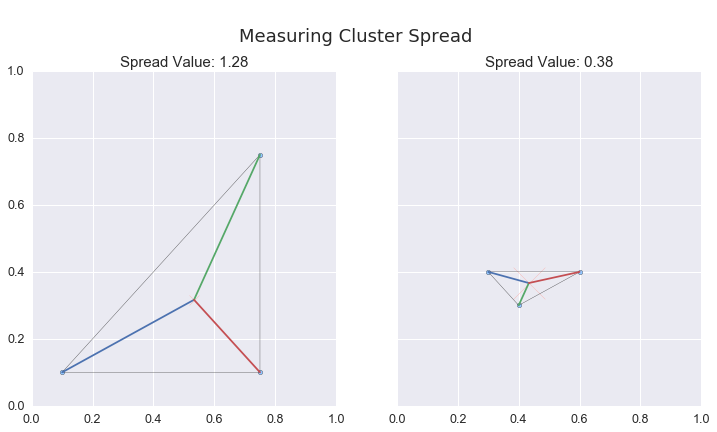

In [462]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True, sharex=True)

sup_title =f.suptitle('\nMeasuring Cluster Spread', y=1.05, fontsize=18)


# Spread out cluster
data = np.array([[.1, .1],
                [.75, .75],
                [.75, .1]])

center = np.mean(data, axis = 0)
left_cluster_spread_metric = np.round(cluster_tightness_metric(pd.DataFrame(data), center), 2)

ax1.set_title('Spread Value: {0}'.format(left_cluster_spread_metric))
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])

ax1.scatter(data[:, 0], data[:, 1])

r = matplotlib.patches.Polygon(data, closed = True, fill=False)
ax1.add_artist(r)
ax1.scatter(center[0], center[1], c='r', s=100, marker='x')

p1 = np.vstack([center, data[0]])
ax1.plot(p1[:, 0], p1[:, 1])

p2 = np.vstack([center, data[1]])
ax1.plot(p2[:, 0], p2[:, 1])

p3 = np.vstack([center, data[2]])
ax1.plot(p3[:, 0], p3[:, 1])



# Tightly packed cluster
data = np.array([[.3, .4],
                [.4, .3],
                [.6, .4]])

center = np.mean(data, axis = 0)
right_cluster_spread_metric = np.round(cluster_tightness_metric(pd.DataFrame(data), center), 2)

ax2.set_title('Spread Value: {0}'.format(right_cluster_spread_metric))
ax2.scatter(data[:, 0], data[:, 1])

r = matplotlib.patches.Polygon(data, closed = True, fill=False)
ax2.add_artist(r)
ax2.scatter(center[0], center[1], c='r', s=1000, marker='x')

p1 = np.vstack([center, data[0]])
ax2.plot(p1[:, 0], p1[:, 1])

p2 = np.vstack([center, data[1]])
ax2.plot(p2[:, 0], p2[:, 1])

p3 = np.vstack([center, data[2]])
ax2.plot(p3[:, 0], p3[:, 1])

f.savefig('/users/nickbecker/Python_Projects/cluster_spread_example.png', dpi=f.dpi, bbox_inches='tight',bbox_extra_artists=[sup_title])


It's pretty clear that the cluster of points on the right are more tightly packed than the cluster of points on the left, and the distance metric I created reflects this. The right cluster's Cluster Spread value is roughly 3 times smaller than the left one, which makes sense.


It's easy to see how this works in two dimensions. While I can't visualize how this works in eight dimensions, the logic extends perfectly. I can use my Cluster Spread metric to measure any the spread of any set of points| in 8-D space just like I did in the 2-D space above.

With the math taken care of, it's time to move on to the music.

# Spotify Audio Features Data

The [Spotify API](https://developer.spotify.com/web-api/) is awesome. Most importantly, for this project, Spotify provides access to [audio features](https://developer.spotify.com/web-api/get-audio-features/) for any song in their collection. Audio features are characteristics of songs like danceability, energy, and loudness that Spotify has assigned numerical values to represent.

I decided to use eight of the features. I picked ones that are naturally represented numerically (so I didn't use things like the key and time signature). The eight characteristics I chose are:

1. Acousticness
2. Danceability
3. Energy
4. Valence (a measure of the song's positiveness (happiness, cheerfulness, etc.))
5. Instrumentalness
6. Loudness
7. Speechiness
8. Tempo

With these features, I can represent each song as an 8-dimensional vector. I did a little bit of data transformation to scale all the features to between 0 and 1, since I don't want any one feature to dominate the spread metric.

And that's all there is to it. With my Cluster Spread formula and my features chosen, I'm ready to start ranking artists.


# Ranking the Spotify Global Top Artists of 2012-2016

At the end of 2016, Spotify released a playlist of their [Global Top 100 Tracks of the Year](https://open.spotify.com/user/spotifyyearinmusic/playlist/2xKlsGov0EC2fhl6uXDgWZ). There are 75 different artists featured on the playlist, so it seems like the perfect test playlist.

Since there isn't really any agreed upon ground truth in terms of which artists are the most one-dimensional, it's not obvious how to evaluate the results. To some extent, I can compare them to my expectations. But there's obviously some issues with that. Either way, it's time to calculate who the most one-dimensional artists are, based on their top 10 songs.

In [389]:
top100_2016_scores

[(u'DNCE', 1.9799315744619292),
 (u'Robin Schulz', 2.0693291477138893),
 (u'Flo Rida', 2.1263384425545047),
 (u'Calvin Harris', 2.2385561120096957),
 (u'FRENSHIP', 2.42090220214078),
 (u'OneRepublic', 2.4973696596659063),
 (u'Maroon 5', 2.505131933148371),
 (u'Martin Garrix', 2.5796318878436542),
 (u'The Chainsmokers', 2.6186970093057735),
 (u'Kungs', 2.6502484854514696),
 (u'David Guetta', 2.6718932070574399),
 (u'Galantis', 2.6742145987941188),
 (u'Selena Gomez', 2.7020896807987027),
 (u'Drake', 2.7185275708621344),
 (u'Jack \xdc', 2.791501700180945),
 (u'Cheat Codes', 2.7919779843984673),
 (u'Zara Larsson', 2.7983412099253111),
 (u'Snakehips', 2.8642574334095272),
 (u'Desiigner', 2.8935740002315748),
 (u'M\xd8', 2.9571849105096351),
 (u'Nicky Jam', 2.982621828687932),
 (u'ZAYN', 3.0059589883294056),
 (u'Charlie Puth', 3.0212903024502169),
 (u'Enrique Iglesias', 3.0232303500883191),
 (u'Mike Perry', 3.0360312536811125),
 (u'DJ Snake', 3.0631592960753906),
 (u'Rudimental', 3.095149755

In [390]:
globl_top_2012_href = 'https://open.spotify.com/user/spotify/playlist/0gbUKxGN0EdQytMEehGsoa'
globl_top_2013_href = 'https://open.spotify.com/user/spotify/playlist/2kDPYiTtUtm5eZUkVYJ4f0'
globl_top_2014_href = 'https://open.spotify.com/user/spotify/playlist/0KzjapF1zYpPYARZFeBnYm'
globl_top_2015_href = 'https://open.spotify.com/user/spotifyyearinmusic/playlist/6MT7PxSJmrg8O31Z5vx1iJ'
globl_top_2016_href = 'https://open.spotify.com/user/spotifyyearinmusic/playlist/2xKlsGov0EC2fhl6uXDgWZ'

In [391]:
top100_2012_artist_dict, top100_2012_scores = evaluate_artists_in_playlist('spotify',
                                                                           '0gbUKxGN0EdQytMEehGsoa')

Gotye
Carly Rae Jepsen
fun.
Flo Rida
Already created dataframe for u'Flo Rida'
Train
Nicki Minaj
Maroon 5
David Guetta
u'Loreen' not popular enough
Rihanna
Avicii
Skrillex
Michel Teló
Snoop Dogg
LMFAO
One Direction
Already created dataframe for u'fun.'
Already created dataframe for u'Flo Rida'
JAY Z
Already created dataframe for u'Rihanna'
Already created dataframe for u'David Guetta'
Coldplay
PSY
Adele
Pitbull
Drake
Kelly Clarkson
Sean Paul
Justin Bieber
Lil Wayne
Already created dataframe for u'Maroon 5'
Chris Brown
Already created dataframe for u'Maroon 5'
Already created dataframe for u'David Guetta'
u'Alina Devecerski' not popular enough
M83
Laleh
u'Panetoz' not popular enough
AWOLNATION
will.i.am
Ed Sheeran
Simple Plan
Already created dataframe for u'LMFAO'
Taio Cruz
Already created dataframe for u'Skrillex'
Alex Clare
The Wanted
u'Tacabro' not popular enough
Swedish House Mafia
Owl City
Foster The People
Jennifer Lopez
Already created dataframe for u'Swedish House Mafia'
Far Eas

In [407]:
joblib.dump(top100_2012_artist_dict, '/users/nickbecker/Python_Projects/top100_2012_artist_dict.pkl')

['/users/nickbecker/Python_Projects/top100_2012_artist_dict.pkl']

In [392]:
top100_2012_scores

[(u'Foster The People', 1.8585251264266909),
 (u'PSY', 1.9450003521764345),
 (u'Carly Rae Jepsen', 1.988392336346674),
 (u'Flo Rida', 2.1263384425545047),
 (u'Pitbull', 2.1302008426707255),
 (u'Calvin Harris', 2.2385561120096957),
 (u'Taio Cruz', 2.3505685299233261),
 (u'Owl City', 2.3981965124433411),
 (u'Far East Movement', 2.4812367658633936),
 (u'Maroon 5', 2.505131933148371),
 (u'Snoop Dogg', 2.6019008370111165),
 (u'Avicii', 2.6310694613681802),
 (u'David Guetta', 2.6718932070574399),
 (u'Chris Brown', 2.7038690116298629),
 (u'Drake', 2.7185275708621344),
 (u'Neon Trees', 2.736534682750805),
 (u'Nickelback', 2.7710418289405454),
 (u'Gym Class Heroes', 2.7785982297379772),
 (u'will.i.am', 2.7996412914414366),
 (u'Skrillex', 2.8203131326244772),
 (u'The Wanted', 2.8444116662208421),
 (u'Of Monsters and Men', 2.9399677274616129),
 (u'M83', 3.0086412832490357),
 (u'Tyga', 3.022428194339414),
 (u'LMFAO', 3.0364324722097753),
 (u'Katy Perry', 3.0589765471645687),
 (u'Simple Plan', 3.07

In [369]:
top100_2013_artist_dict, top100_2013_scores = evaluate_artists_in_playlist('spotify',
                                                                           '2kDPYiTtUtm5eZUkVYJ4f0')

Macklemore & Ryan Lewis
Avicii
Already created dataframe for u'Macklemore & Ryan Lewis'
Daft Punk
Imagine Dragons
Passenger
Robin Thicke
P!nk
The Lumineers
Calvin Harris
Justin Timberlake
Swedish House Mafia
will.i.am
Bastille
Bruno Mars
Already created dataframe for u'Bruno Mars'
Miley Cyrus
The Script
Already created dataframe for u'Calvin Harris'
Rihanna
Already created dataframe for u'Avicii'
Katy Perry
Pitbull
Lorde
Already created dataframe for u'Miley Cyrus'
Naughty Boy
JAY Z
Of Monsters and Men
AWOLNATION
OneRepublic
Already created dataframe for u'Imagine Dragons'
Already created dataframe for u'Macklemore & Ryan Lewis'
Icona Pop
Already created dataframe for u'Imagine Dragons'
Ellie Goulding
Already created dataframe for u'will.i.am'
Already created dataframe for u'Bruno Mars'
Drake
Already created dataframe for u'P!nk'
Mumford & Sons
Already created dataframe for u'Imagine Dragons'
Already created dataframe for u'Avicii'
Already created dataframe for u'Avicii'
A$AP Rocky
Kes

In [408]:
joblib.dump(top100_2013_artist_dict, '/users/nickbecker/Python_Projects/top100_2013_artist_dict.pkl')

['/users/nickbecker/Python_Projects/top100_2013_artist_dict.pkl']

In [374]:
top100_2014_artist_dict, top100_2014_scores = evaluate_artists_in_playlist('spotify',
                                                                           '0KzjapF1zYpPYARZFeBnYm')

Pharrell Williams
Clean Bandit
Calvin Harris
Katy Perry
John Legend
Pitbull
MAGIC!
Mr. Probz
Ariana Grande
OneRepublic
Nico & Vinz
Sia
Iggy Azalea
Sam Smith
Imagine Dragons
Coldplay
Ed Sheeran
Bastille
David Guetta
Already created dataframe for u'Coldplay'
Vance Joy
Lorde
Jason Derulo
Passenger
Avicii
Already created dataframe for u'Ariana Grande'
Already created dataframe for u'Jason Derulo'
Maroon 5
Eminem
Milky Chance
Meghan Trainor
Already created dataframe for u'Imagine Dragons'
Lilly Wood and The Prick
Already created dataframe for u'Lorde'
Tove Lo
Disclosure
Already created dataframe for u'Sam Smith'
Already created dataframe for u'Ed Sheeran'
Aloe Blacc
A Great Big World
Already created dataframe for u'Jason Derulo'
Jessie J
Tiësto
DJ Snake
MKTO
Macklemore & Ryan Lewis
Already created dataframe for u'Calvin Harris'
Beyoncé
Ellie Goulding
Already created dataframe for u'Ed Sheeran'
Becky G
Shakira
The Chainsmokers
Already created dataframe for u'Iggy Azalea'
Kiesza
Arctic Monkey

In [409]:
joblib.dump(top100_2014_artist_dict, '/users/nickbecker/Python_Projects/top100_2014_artist_dict.pkl')

['/users/nickbecker/Python_Projects/top100_2014_artist_dict.pkl']

In [375]:
top100_2015_artist_dict, top100_2015_scores = evaluate_artists_in_playlist('spotifyyearinmusic',
                                                                           '6MT7PxSJmrg8O31Z5vx1iJ')

Major Lazer
OMI
Mark Ronson
Wiz Khalifa
Ellie Goulding
Ed Sheeran
Maroon 5
Jack Ü
Hozier
The Weeknd
Already created dataframe for u'The Weeknd'
Kygo
Jason Derulo
Already created dataframe for u'Kygo'
Flo Rida
Justin Bieber
WALK THE MOON
Rihanna
Ne-Yo & Pitbull
David Guetta
Lost Frequencies
Already created dataframe for u'The Weeknd'
Fifth Harmony
Sia
Avicii
Sam Smith
Calvin Harris
Already created dataframe for u'Ed Sheeran'
Nicky Jam
Felix Jaehn
Deorro
Already created dataframe for u'Calvin Harris'
Already created dataframe for u'Sia'
Ariana Grande
Selena Gomez
Carly Rae Jepsen
Already created dataframe for u'Sam Smith'
Years & Years
Already created dataframe for u'Flo Rida'
Lilly Wood and The Prick
Jessie J
James Bay
Already created dataframe for u'Avicii'
Alesso
Shawn Mendes
Tove Lo
Drake
One Direction
Already created dataframe for u'Calvin Harris'
Galantis
R. City
Already created dataframe for u'Ariana Grande'
DJ Snake
Robin Schulz
Already created dataframe for u'Rihanna'
Natalie La

In [410]:
joblib.dump(top100_2015_artist_dict, '/users/nickbecker/Python_Projects/top100_2015_artist_dict.pkl')

['/users/nickbecker/Python_Projects/top100_2015_artist_dict.pkl']

In [376]:
top100_2016_artist_dict, top100_2016_scores = evaluate_artists_in_playlist('spotifyyearinmusic',
                                                                           '2xKlsGov0EC2fhl6uXDgWZ')

Drake
Mike Posner
The Chainsmokers
Rihanna
Sia
Justin Bieber
Fifth Harmony
Calvin Harris
Lukas Graham
Alan Walker
Twenty One Pilots
Already created dataframe for u'Justin Bieber'
Major Lazer
Already created dataframe for u'The Chainsmokers'
G-Eazy
Desiigner
Already created dataframe for u'Major Lazer'
Jonas Blue
ZAYN
Justin Timberlake
DNCE
Already created dataframe for u'Drake'
Already created dataframe for u'The Chainsmokers'
Zara Larsson
DJ Snake
gnash
Already created dataframe for u'Rihanna'
Shawn Mendes
Already created dataframe for u'Twenty One Pilots'
Already created dataframe for u'Twenty One Pilots'
Already created dataframe for u'DJ Snake'
Already created dataframe for u'Shawn Mendes'
Galantis
Cheat Codes
Already created dataframe for u'Justin Bieber'
Charlie Puth
Flo Rida
Kygo
Adele
Already created dataframe for u'Zara Larsson'
Ariana Grande
Kiiara
Kungs
Mike Perry
Already created dataframe for u'Major Lazer'
Already created dataframe for u'Drake'
Robin Schulz
Coldplay
Selena

In [427]:
top100_2016_artist_dict['DNCE']

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,track_uri,track_name
0,0.156000,0.774,0.765,0.000000,4,0.0373,-5.439,0.0502,119.001,4,0.910,spotify:track:76hfruVvmfQbw0eYn1nmeC,Cake By The Ocean
1,0.133000,0.558,0.801,0.000000,7,0.3920,-5.795,0.1310,105.006,4,0.787,spotify:track:7ciLq0Cip0yxiz6KANrOUq,Toothbrush
2,0.001690,0.655,0.696,0.000000,1,0.0352,-5.121,0.0386,102.029,4,0.838,spotify:track:2igbKtoBMXdYgYPkCpl0V4,Body Moves
3,0.266000,0.718,0.654,0.000000,8,0.3360,-6.871,0.0356,102.003,4,0.576,spotify:track:2lBqyCeue1bCd6HCZtKXHu,Truthfully
4,0.056200,0.718,0.678,0.000000,5,0.1920,-4.933,0.0428,110.019,4,0.883,spotify:track:49X8pWDpmFpAITVUaudkcN,Good Day
5,0.081500,0.690,0.739,0.000000,7,0.0784,-5.934,0.0641,112.997,4,0.808,spotify:track:3raTxbibtTZruSHwldoVO9,Pay My Rent
6,0.073100,0.703,0.747,0.000000,9,0.0671,-5.131,0.0772,94.004,4,0.514,spotify:track:2T2tqZzWlZo92Xdxluu887,Be Mean
7,0.001420,0.635,0.952,0.000002,7,0.1010,-4.647,0.0457,129.990,4,0.732,spotify:track:1Nj0Vy9jjuLW28pV0TApfw,Blown
8,0.000702,0.750,0.693,0.000053,10,0.2040,-4.790,0.0550,111.952,4,0.542,spotify:track:70dijpsCUYbKuReG6oYguZ,Unsweet
9,0.004990,0.827,0.725,0.000087,1,0.1890,-5.875,0.0461,114.051,4,0.873,spotify:track:2qTPEvJeijDPmmTbU5O5i5,DNCE


In [411]:
joblib.dump(top100_2016_artist_dict, '/users/nickbecker/Python_Projects/top100_2016_artist_dict.pkl')

['/users/nickbecker/Python_Projects/top100_2016_artist_dict.pkl']

In [443]:
combined = list(set(top100_2012_scores + top100_2013_scores + top100_2014_scores + top100_2015_scores + top100_2016_scores))
combined.sort(key=lambda x: x[1])
combined = pd.DataFrame(combined, columns=['artist', 'cluster_spread'])
combined

,artist,cluster_spread
0,Kesha,1.722884
1,Foster The People,1.858525
2,Fall Out Boy,1.928683
3,American Authors,1.936762
4,PSY,1.945000
5,DNCE,1.979932
6,Carly Rae Jepsen,1.988392
7,Alesso,2.030781
8,WALK THE MOON,2.032803
9,Robin Schulz,2.069329


In [447]:
combined.to_csv('/users/nickbecker/Python_Projects/one_dimensional_popular_artists_ranking.csv',
                index=False,
                encoding = 'ISO-8859-1')

In [449]:
least_spread = combined[:10]

In [450]:
def plot_most_oned_artists():
    import seaborn as sns
    
    f = plt.figure(figsize = (12, 8))
    ax = plt.axes()
    sns.set(font_scale = 1.25)
    sns.set_color_codes('pastel')
    sns.barplot(x = 'cluster_spread', y = 'artist', data = least_spread, color = 'b')
    plt.xlabel('Cluster Spread Value', size = 15)
    plt.ylabel('Artist', size = 15)
    ax.xaxis.set_label_position('bottom')
    sns.despine(left = True, bottom = True)
    plt.title('Most One-Dimensional Artists 2012-2016', size = 20)

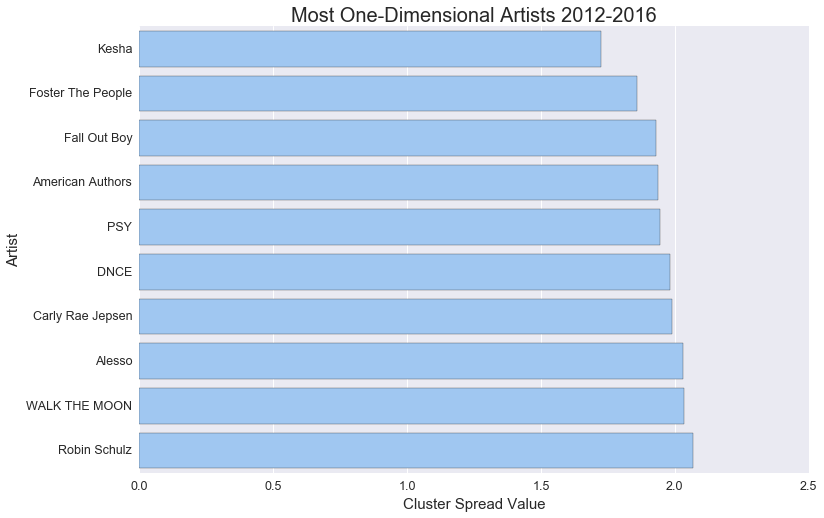

In [451]:
plot_most_oned_artists()

# Kesha Wins Most One-Dimensional of All Time (so far)

I didn't calculate Cluster Spread for every major artist, but I did try a lot of bands (over 500). After seeing the results from 2012-2016, I tested a few random bands from history that I thought might also have a chance to win the title.

In a shocking turn of a events, Kesha managed to narrowly beat out Creed (a heavy favorite going into this process) as the most one-dimensional of all time.

But don't worry Creed fans. There's always a chance they'll come out of retirement and write a new hit that will [take them higher](https://www.youtube.com/watch?v=DhAFbwoaH7o).

---

For those interested in recreating or extending this analysis, you can access the code in a Jupyter Notebook [here]().

In [463]:
evaluate_artist_by_name_top_tracks('creed')

('creed', 1.7505835858396976, u'43sZBwHjahUvgbx1WNIkIz')

In [413]:
tup = get_artist_id_from_name('american authors')
sp.artist(tup[1]) # maybe 60 is a good threshold; can range from 0 to 100 but no data on distribution

{u'external_urls': {u'spotify': u'https://open.spotify.com/artist/0MlOPi3zIDMVrfA9R04Fe3'},
 u'followers': {u'href': None, u'total': 276403},
 u'genres': [u'brooklyn indie',
  u'folk-pop',
  u'indie poptimism',
  u'neo mellow',
  u'pop',
  u'pop rock'],
 u'href': u'https://api.spotify.com/v1/artists/0MlOPi3zIDMVrfA9R04Fe3',
 u'id': u'0MlOPi3zIDMVrfA9R04Fe3',
 u'images': [{u'height': 1257,
   u'url': u'https://i.scdn.co/image/a991a6d6bd48b35c84a81e2dd6d8621c9745a31d',
   u'width': 1000},
  {u'height': 804,
   u'url': u'https://i.scdn.co/image/0c5ac9854e2756c26c9cc18c9f8331b995ef1397',
   u'width': 640},
  {u'height': 251,
   u'url': u'https://i.scdn.co/image/3a3ca2f0b64551b79b6963722a652bcc0b5b4a8a',
   u'width': 200},
  {u'height': 80,
   u'url': u'https://i.scdn.co/image/1240137c4f2141279f2d2f86d0c7a6299113d8c4',
   u'width': 64}],
 u'name': u'American Authors',
 u'popularity': 68,
 u'type': u'artist',
 u'uri': u'spotify:artist:0MlOPi3zIDMVrfA9R04Fe3'}

In [352]:
def get_artist_popularity(artist_id):
    data = sp.artist(artist_id)
    popularity = data['popularity']
    return popularity